# 多头注意力机制

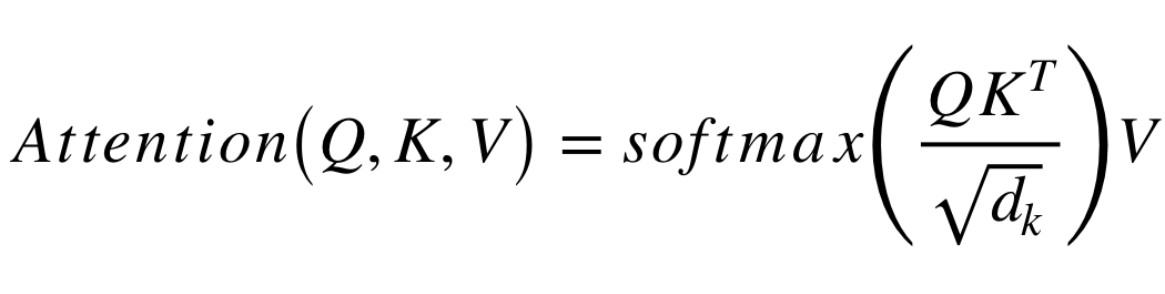

In [2]:
from IPython.display import Image
Image(filename='./photo/qkv.png')

In [3]:
import torch
from torch import nn
import math
from bertviz.transformers_neuron_view import BertModel, BertConfig
from transformers import BertTokenizer

## 1. model config and load

In [4]:
max_length = 256
model_name = 'bert-base-uncased'

config = BertConfig.from_pretrained(model_name, output_attentions=True, output_hidden_states=True, 
                                    return_dict=True, max_position_embeddings=max_length)

tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel(config).from_pretrained(model_name)
model = model.eval()

/root/miniconda3/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [5]:
model.config

{
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 2,
  "output_attentions": true,
  "output_hidden_states": false,
  "pad_token_id": 0,
  "torchscript": false,
  "type_vocab_size": 2,
  "vocab_size": 30522
}

In [6]:
# 单个注意力头的 size
att_head_size = int(model.config.hidden_size / model.config.num_attention_heads)
att_head_size

64

In [7]:
model.encoder   # 模型的 encoder 部分

BertEncoder(
  (layer): ModuleList(
    (0-11): 12 x BertLayer(
      (attention): BertAttention(
        (self): BertSelfAttention(
          (query): Linear(in_features=768, out_features=768, bias=True)
          (key): Linear(in_features=768, out_features=768, bias=True)
          (value): Linear(in_features=768, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (output): BertSelfOutput(
          (dense): Linear(in_features=768, out_features=768, bias=True)
          (LayerNorm): BertLayerNorm()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (intermediate): BertIntermediate(
        (dense): Linear(in_features=768, out_features=3072, bias=True)
      )
      (output): BertOutput(
        (dense): Linear(in_features=3072, out_features=768, bias=True)
        (LayerNorm): BertLayerNorm()
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
)

In [8]:
# 获得多头注意力机制 query 矩阵的其中一个头（多头注意力机制通过分块矩阵的方式实现）
model.encoder.layer[0].attention.self.query.weight.T[:, 64:128]

tensor([[-0.0112, -0.0324, -0.0615,  ..., -0.0383,  0.0031,  0.0059],
        [ 0.0260, -0.0067, -0.0616,  ...,  0.1097,  0.0029, -0.0540],
        [-0.0169,  0.0232,  0.0068,  ...,  0.0124, -0.0168,  0.0301],
        ...,
        [ 0.1083,  0.0056,  0.0968,  ...,  0.0188, -0.0171,  0.0141],
        [-0.0436, -0.1032, -0.1035,  ...,  0.0138, -0.0488, -0.0453],
        [-0.0611,  0.0224, -0.0320,  ...,  0.0376,  0.0186, -0.0482]],
       grad_fn=<SliceBackward0>)

## 2. data

In [9]:
sentence = 'hello, bob. how are you today, has anything fun happened ?'
inputs_tests = tokenizer(sentence, truncation=True, padding=True, max_length=max_length, return_tensors='pt')

In [10]:
inputs_tests.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [11]:
inputs_tests['input_ids'].shape

torch.Size([1, 16])

## 3. model output

In [12]:
model_output = model(**inputs_tests)

In [13]:
model_output

(tensor([[[-0.2609, -0.2714, -0.0764,  ..., -0.3670,  0.5289,  0.2424],
          [-0.1569, -0.2513, -0.0732,  ...,  0.2651,  1.2653,  0.1474],
          [-0.8185,  0.3688,  0.4802,  ..., -0.3195,  1.0063, -0.0218],
          ...,
          [-0.0759, -1.4122, -0.2359,  ...,  0.0935, -0.0476, -0.3172],
          [-0.2730, -1.4563, -0.2354,  ..., -0.0366,  0.2242,  0.0823],
          [ 0.4788, -0.0206, -0.3046,  ...,  0.1216, -0.3997, -0.1680]]],
        grad_fn=<AddBackward0>),
 tensor([[-0.8907, -0.4534, -0.9740,  0.7853,  0.7506, -0.2516,  0.9021,  0.2606,
          -0.9281, -1.0000, -0.7577,  0.9850,  0.9663,  0.7611,  0.9162, -0.8453,
          -0.7060, -0.6156,  0.2853, -0.0679,  0.7317,  1.0000, -0.1487,  0.3560,
           0.5330,  0.9985, -0.9178,  0.9195,  0.9517,  0.6259, -0.6549,  0.1752,
          -0.9869, -0.2129, -0.9746, -0.9880,  0.4754, -0.6537, -0.0288,  0.0805,
          -0.8592,  0.3656,  1.0000,  0.2511,  0.5698, -0.2740, -1.0000,  0.2999,
          -0.8665,  0.9853

- last_hidden_state (batch_size, sequence_length, hidden_size) : last hidden state which is outputted from the last BertLayer
- pooler_output (batch_size, hidden_size) : output of the Pooler layer
- hidden_states (batch_size, sequence_length, hidden_size): hidden-states of the model at the output of each BertLayer plus the initial embedding
- attentions (batch_size, num_heads, sequence_length, sequence_length): one for each BertLayer. Attentions weights after the attention SoftMax

In [14]:
len(model_output)

3

In [15]:
model_output[-1][0].keys()

dict_keys(['attn', 'queries', 'keys'])

In [16]:
model_output[-1][0]['attn'].shape

torch.Size([1, 12, 16, 16])

In [17]:
model_output[-1][0]['attn'][0, 0, :, :]

tensor([[0.0505, 0.0387, 0.0411, 0.0246, 0.0960, 0.0470, 0.0527, 0.0349, 0.0472,
         0.0505, 0.0641, 0.0639, 0.0313, 0.0358, 0.0702, 0.2515],
        [0.0382, 0.0470, 0.0204, 0.0943, 0.0200, 0.0683, 0.0406, 0.1050, 0.0566,
         0.0217, 0.0531, 0.1193, 0.0598, 0.1055, 0.0945, 0.0558],
        [0.0472, 0.0526, 0.0406, 0.0757, 0.0673, 0.0682, 0.0647, 0.0441, 0.0551,
         0.0481, 0.0855, 0.0651, 0.0477, 0.0785, 0.0907, 0.0689],
        [0.0335, 0.0523, 0.0492, 0.0470, 0.0685, 0.0791, 0.0479, 0.0575, 0.0252,
         0.0511, 0.0631, 0.1526, 0.0376, 0.0925, 0.1120, 0.0310],
        [0.0472, 0.0396, 0.0853, 0.0588, 0.0833, 0.0535, 0.0445, 0.0559, 0.0482,
         0.0848, 0.0523, 0.0561, 0.0385, 0.0690, 0.1090, 0.0741],
        [0.0557, 0.0346, 0.0989, 0.0550, 0.1012, 0.0263, 0.0718, 0.0675, 0.0292,
         0.0952, 0.0801, 0.0495, 0.0338, 0.0595, 0.0705, 0.0712],
        [0.0709, 0.0376, 0.0736, 0.0504, 0.0557, 0.0677, 0.0605, 0.0408, 0.0326,
         0.0740, 0.1100, 0.0470, 0.02

In [18]:
model_output[-1][0]['attn'][0, 0, :, :].shape

torch.Size([16, 16])

In [19]:
model_output[-1][0]['attn'][0, 0, :, :].sum(dim=-1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       grad_fn=<SumBackward1>)

## 4. from scratch

### 获得 embedding 层的输出

In [20]:
emb_output = model.embeddings(inputs_tests['input_ids'], inputs_tests['token_type_ids'])   # embedding 层得到的结果

In [21]:
emb_output.shape

torch.Size([1, 16, 768])

### 获得第一个 encoder

In [22]:
model.encoder.layer[0]   # 第一个 encoder

BertLayer(
  (attention): BertAttention(
    (self): BertSelfAttention(
      (query): Linear(in_features=768, out_features=768, bias=True)
      (key): Linear(in_features=768, out_features=768, bias=True)
      (value): Linear(in_features=768, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (output): BertSelfOutput(
      (dense): Linear(in_features=768, out_features=768, bias=True)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (intermediate): BertIntermediate(
    (dense): Linear(in_features=768, out_features=3072, bias=True)
  )
  (output): BertOutput(
    (dense): Linear(in_features=3072, out_features=768, bias=True)
    (LayerNorm): BertLayerNorm()
    (dropout): Dropout(p=0.1, inplace=False)
  )
)

### 根据公式，逐步计算注意力矩阵

In [23]:
# emb_output[0].shape: 16 * 768
# 权重矩阵 query.weight.T.shape: 768 * 768
# 权重矩阵的单头 query.weight.T[:, :att_head_size]: 768 * 64

# 16 * 64
Q_first_head_first_layer = emb_output[0] @ model.encoder.layer[0].attention.self.query.weight.T[:, :att_head_size] \
                            + model.encoder.layer[0].attention.self.query.bias[:att_head_size]

In [24]:
# 16 * 64
K_first_head_first_layer = emb_output[0] @ model.encoder.layer[0].attention.self.key.weight.T[:, :att_head_size] \
                            + model.encoder.layer[0].attention.self.key.bias[:att_head_size]

In [25]:
# 分数矩阵 (16 * 64) * (64 * 16) ==> 16 * 16
attn_scores = torch.nn.Softmax(dim=-1)(Q_first_head_first_layer @ K_first_head_first_layer.T / math.sqrt(att_head_size))

In [26]:
attn_scores  # 和上面一致

tensor([[0.0505, 0.0387, 0.0411, 0.0246, 0.0960, 0.0470, 0.0527, 0.0349, 0.0472,
         0.0505, 0.0641, 0.0639, 0.0313, 0.0358, 0.0702, 0.2515],
        [0.0382, 0.0470, 0.0204, 0.0943, 0.0200, 0.0683, 0.0406, 0.1050, 0.0566,
         0.0217, 0.0531, 0.1193, 0.0598, 0.1055, 0.0945, 0.0558],
        [0.0472, 0.0526, 0.0406, 0.0757, 0.0673, 0.0682, 0.0647, 0.0441, 0.0551,
         0.0481, 0.0855, 0.0651, 0.0477, 0.0785, 0.0907, 0.0689],
        [0.0335, 0.0523, 0.0492, 0.0470, 0.0685, 0.0791, 0.0479, 0.0575, 0.0252,
         0.0511, 0.0631, 0.1526, 0.0376, 0.0925, 0.1120, 0.0310],
        [0.0472, 0.0396, 0.0853, 0.0588, 0.0833, 0.0535, 0.0445, 0.0559, 0.0482,
         0.0848, 0.0523, 0.0561, 0.0385, 0.0690, 0.1090, 0.0741],
        [0.0557, 0.0346, 0.0989, 0.0550, 0.1012, 0.0263, 0.0718, 0.0675, 0.0292,
         0.0952, 0.0801, 0.0495, 0.0338, 0.0595, 0.0705, 0.0712],
        [0.0709, 0.0376, 0.0736, 0.0504, 0.0557, 0.0677, 0.0605, 0.0408, 0.0326,
         0.0740, 0.1100, 0.0470, 0.02

In [27]:
attn_scores.sum(dim=-1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       grad_fn=<SumBackward1>)

In [28]:
# 16 * 64
V_first_head_first_layer = emb_output[0] @ model.encoder.layer[0].attention.self.value.weight.T[:, :att_head_size] \
                            + model.encoder.layer[0].attention.self.value.bias[:att_head_size]
V_first_head_first_layer

tensor([[ 2.3786, -0.0979, -0.2844,  ...,  0.0970, -0.1854,  0.2113],
        [ 0.2274,  0.9015,  0.9872,  ..., -0.9599, -0.2232, -0.6695],
        [-0.1230,  1.0479, -0.0501,  ...,  0.7403,  0.1788,  0.1473],
        ...,
        [ 0.0384,  0.0774,  0.0563,  ...,  0.2730, -0.3040,  0.0571],
        [-0.2394, -0.2845,  0.7570,  ..., -0.5891, -0.3552,  0.4161],
        [ 0.5240, -0.0320,  0.1499,  ...,  0.4197, -0.0404,  0.0588]],
       grad_fn=<AddBackward0>)

In [29]:
attn_emb = attn_scores @ V_first_head_first_layer  # 注意力矩阵

In [30]:
attn_emb.shape

torch.Size([16, 64])

In [31]:
attn_emb

tensor([[ 0.1365,  0.2426,  0.0984,  ...,  0.1887, -0.0684,  0.1362],
        [ 0.1118,  0.2276,  0.0671,  ...,  0.1481, -0.1980,  0.1124],
        [ 0.0087,  0.2867,  0.0585,  ...,  0.1182, -0.0930,  0.1260],
        ...,
        [-0.0667,  0.3284,  0.1502,  ...,  0.0872, -0.0363,  0.1867],
        [-0.0435,  0.3528,  0.0476,  ...,  0.1699, -0.0458,  0.1451],
        [ 0.0262,  0.3189,  0.0991,  ...,  0.1572, -0.0772,  0.1643]],
       grad_fn=<MmBackward0>)

### 5. all

In [32]:
Q_first_layer = emb_output[0] @ model.encoder.layer[0].attention.self.query.weight.T \
                            + model.encoder.layer[0].attention.self.query.bias
K_first_layer = emb_output[0] @ model.encoder.layer[0].attention.self.key.weight.T \
                            + model.encoder.layer[0].attention.self.key.bias
V_first_layer = emb_output[0] @ model.encoder.layer[0].attention.self.value.weight.T \
                            + model.encoder.layer[0].attention.self.value.bias

In [33]:
Q_first_layer.shape, K_first_layer.shape, V_first_layer.shape

(torch.Size([16, 768]), torch.Size([16, 768]), torch.Size([16, 768]))

In [34]:
scores = torch.nn.Softmax(dim=-1)(Q_first_layer @ K_first_layer.T / math.sqrt(64))

In [35]:
scores.shape

torch.Size([16, 16])

In [36]:
attn_all = scores @ V_first_layer   # 多头注意力机制下，注意力矩阵
attn_all

tensor([[ 2.3786, -0.0979, -0.2844,  ..., -0.0202,  0.1028,  0.1020],
        [ 2.3786, -0.0979, -0.2844,  ..., -0.0202,  0.1028,  0.1020],
        [ 0.2267,  0.9006,  0.9839,  ...,  0.5386, -0.4294, -0.5034],
        ...,
        [ 0.3939,  0.2800,  0.3118,  ..., -0.1035, -0.6547,  0.4015],
        [ 0.4155, -0.0086,  0.1375,  ..., -0.1028,  0.4915, -0.2063],
        [ 2.3380, -0.0975, -0.2733,  ..., -0.0198,  0.0991,  0.1014]],
       grad_fn=<MmBackward0>)

In [37]:
attn_all.shape

torch.Size([16, 768])